### Задача проекта

Провести анализ клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.
1. Проведите исследовательский анализ данных
2. Выделите портреты клиентов, которые склонны уходить из банка
3. Сформулируйте и проверьте статистические гипотезы

### Оглавление

1. [Проверка данных и их подготовка для анализа](#Проверка)
2. [Исследовательский анализ данных](#Исследование)
3. [Статистический анализ данных](#Статистика)
4. [Кластеризация пользователей](#Кластеризация)
5. [Машинное обучение и предсказание оттока](#Предсказания)
6. [Выводы](#Выводы)
7. [Список источников](#Источники)

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('bank_dataset.csv')

### 1. Проверка данных и их подготовка для анализа <a id="Проверка"></a>

*Проверяем наполненность датасета информацией, правильные форматы столбцов*

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid             10000 non-null int64
score              10000 non-null int64
City               10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Objects            10000 non-null int64
Balance            6383 non-null float64
NumOfProducts      10000 non-null int64
CreditCard         10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Churn              10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


*Проверяем наличие дубликатов в данных. Они отсутствуют*

In [105]:
data.duplicated().sum()

0

### 2. Исследовательский анализ данных <a id="Исследование"></a>

*Проверяем количество клиентов с нулевым балансом у групп оттока и постоянных клиентов*

In [106]:
data[data['Balance'].isna()].groupby('Churn')['userid'].count().reset_index()

,Churn,userid
0,0,3117
1,1,500


##### Вывод
В столбце баланса карты есть пропуски. Почитав комментарии тимлида, узнала, что эти пропуски - нулевой баланс, есть и у оттока, и у постоянных клиентов, причем у постоянных клиентов в разы больше. У оттока причины понятны, сняли деньги, закрыли карту. У постоянных клиентов может существовать другая, более удобная и выгодная карта, на которую переводятся все деньги с этой карты.

*Для упрощения работы с данными добавляем индексы по городам и полу, делим группы оттока и постоянных клиентов на 2 разных датасета*

In [107]:
data.loc[data['City'] == 'Ярославль', 'City_code'] = 1
data.loc[data['City'] == 'Рыбинск', 'City_code'] = 2
data.loc[data['City'] == 'Ростов Великий', 'City_code'] = 3
data.loc[data['Gender'] == 'М', 'Gender_code'] = 1
data.loc[data['Gender'] == 'Ж', 'Gender_code'] = 0

not_churn = data[data['Churn'] == 0]
churn = data[data['Churn'] == 1]

*Сравниваем средние значения по столбцам по 2м новым датасетам*

In [108]:
not_churn_mean = not_churn.mean().round(2).reset_index()
churn_mean = churn.mean().round(2).reset_index()
mean_df = not_churn_mean.merge(churn_mean, on='index')
mean_df.columns = ['set','not_churn','churn']
mean_df

,set,not_churn,churn
0,userid,15733903.88,15732787.96
1,score,651.85,645.35
2,Age,37.41,44.84
3,Objects,5.03,4.93
4,Balance,119535.86,120746.97
5,NumOfProducts,1.54,1.48
6,CreditCard,0.71,0.70
7,IsActiveMember,0.55,0.36
8,EstimatedSalary,99738.39,101465.68
9,Churn,0.00,1.00


##### Вывод
Судя по среднему значению, разница между оттоком и постоянными клиентами значительна в возрасте и активности клиента.

*Строим графики количественных данных по количеству клиентов по 2м новым датасетам*

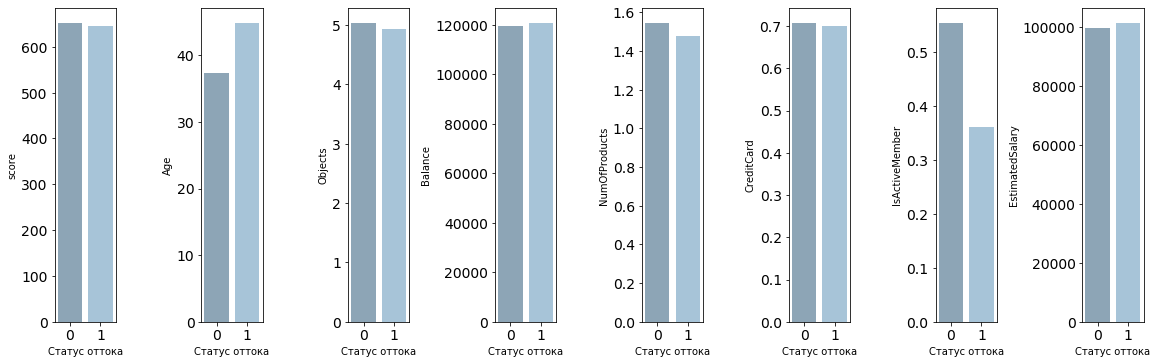

In [109]:
plt.subplots(figsize=(20,5))
one = 0
plt.style.use('seaborn-dark-palette')
for i in churn.columns:
    if churn[i].dtype != ('O') and i not in ('userid','Churn','City_code','Gender_code'):
        one += 1
        sns.barplot(data['Churn'], data[i], ax=plt.subplot(1,10,one), alpha=0.6, ci=None, palette="Blues_d")
    plt.tight_layout(0.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Статус оттока')

##### Вывод
По графикам количества клиентов в двух группах оттока также видим существенную разницу только по возрасту и активности клиента. Не самые показательные данные.

*Строим графики качественных данных по доле значений в столбце по 2м новым датасетам*

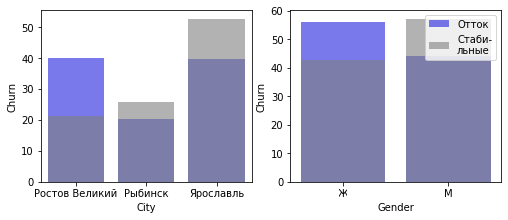

In [110]:
plt.subplots(figsize=(7,3))
one = 0
plt.style.use('seaborn-dark-palette')

for i in churn.columns:
    if churn[i].dtype == ('O'):
        one += 1
        new1 = (churn.groupby(i)['Churn'].count() / len(churn[i]) * 100).reset_index()
        new2 = (not_churn.groupby(i)['Churn'].count() / len(not_churn[i]) * 100).reset_index()
        ax = sns.barplot(x=new1[i], y=new1['Churn'], ax=plt.subplot(1,2,one), alpha=0.6, label='Отток', color='blue')
        sns.barplot(x=new2[i], y=new2['Churn'], ax=ax, alpha=0.6, label='Стаби-\nльные', color='gray')
    plt.tight_layout(0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
plt.legend()

##### Вывод
Сравнив доли по городам и полу в группах оттока и постоянных покупателей можно сделать выводы:
* наибольшее количество клиентов из группы оттока наблюдается в городах Ростов Великий и Ярославль
* наибольшее количество стабильных клиентов проживает в Ярославле
* в группе оттока женщин на 10% больше, чем мужчин. У стабильных клиентов мужчин на 15% больше, чем женщин

*Строим графики качественных данных по проценту оттока в общем количестве клиентов*

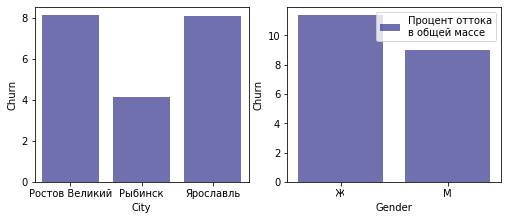

In [111]:
plt.subplots(figsize=(7,3))
one = 0
for i in churn.columns:
    if churn[i].dtype == ('O'):
        one += 1
        new3 = (churn.groupby(i)['Churn'].count() / len(data[i]) * 100).reset_index()
        sns.barplot(x=new3[i], y=new3['Churn'], ax=plt.subplot(1,2,one), alpha=0.6, label='Процент оттока\nв общей массе', color='darkblue')      
    plt.tight_layout(0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
plt.legend()

##### Вывод
В общей массе процент оттока в Ростове Великом и Ярославле достигает 8%. Процент оттока женщин составляет почти 15%.

#### Выводы:
В столбце баланса карты есть пропуски. Почитав комментарии тимлида, узнала, что эти пропуски - нулевой баланс, есть и у оттока, и у постоянных клиентов, причем у постоянных клиентов в разы больше. У оттока причины понятны, сняли деньги, закрыли карту. У постоянных клиентов может существовать другая, более удобная и выгодная карта, на которую переводятся все деньги с этой карты.

Судя по среднему значению, разница между оттоком и постоянными клиентами значительна в возрасте и активности клиента.

По графикам количества клиентов в двух группах оттока также видим существенную разницу только по возрасту и активности клиента. В общей массе процент оттока в Ростове Великом и Ярославле достигает 8%. Процент оттока женщин составляет почти 15%.

На данном этапе посмотрим, что можно сказать об уходящем клиенте. 

Скорее всего это будет женщина, живущая в Ростове Великом и Ярославле. По большей вероятности ей около 45 лет и она неохотно пользуется продуктами банка.
Средние значения и доли групп размыты и не дают точной картинки. Для выделения более четких черт портрета клиента из оттока нужно воспользоваться статистическими методами анализа данных.

### 3. Статистический анализ данных <a id="Статистика"></a>

*Для статистических расчетов заполняем все пропуски в датасетах нулями, удаляем столбцы с качественными параметрами*

In [112]:
not_churn_st = not_churn.drop(['userid','Churn','City','Gender'], axis=1).fillna(0)
churn_st = churn.drop(['userid','Churn','City','Gender'], axis=1).fillna(0)

*Для сравнения количественных значений применим статистический тест о равенстве двух средних*

*Нулевая гипотеза: средние значения двух генеральных совокупностей: группы с оттоком клиентов и без - по взятым из них выборкам равны. Проверим, значима разница между ними или нет*

In [113]:
import scipy.stats as st
alpha = 0.05
for i in churn_st.columns:
    res = st.ttest_ind(not_churn_st[i], churn_st[i])
    if res.pvalue >= alpha:
        print('По столбцу ', i , 'нулевую гипотезу подтверждаем, средняя равна')
    else:
        print('По столбцу ', i , 'нулевую гипотезу отвергаем, разница в средней ощутима')

По столбцу  score нулевую гипотезу отвергаем, разница в средней ощутима
По столбцу  Age нулевую гипотезу отвергаем, разница в средней ощутима
По столбцу  Objects нулевую гипотезу подтверждаем, средняя равна
По столбцу  Balance нулевую гипотезу отвергаем, разница в средней ощутима
По столбцу  NumOfProducts нулевую гипотезу отвергаем, разница в средней ощутима
По столбцу  CreditCard нулевую гипотезу подтверждаем, средняя равна
По столбцу  IsActiveMember нулевую гипотезу отвергаем, разница в средней ощутима
По столбцу  EstimatedSalary нулевую гипотезу подтверждаем, средняя равна
По столбцу  City_code нулевую гипотезу отвергаем, разница в средней ощутима
По столбцу  Gender_code нулевую гипотезу отвергаем, разница в средней ощутима


##### Вывод
По столбцам "Кредитный рейтинг", "Возраст", "Баланс карты", "Количество продуктов", "Активный клиент", "Город", "Пол" можем сделать вывод, что разница в средних ощутима для постоянных клиентов и из группы оттока. 

*Строим матрицу корреляций*

In [114]:
data_cor = data[['score','Age','Objects','Balance','NumOfProducts','EstimatedSalary']]
data_cor.corr()

,score,Age,Objects,Balance,NumOfProducts,EstimatedSalary
score,1.000000,-0.003965,0.000842,-0.004744,0.012238,-0.001384
Age,-0.003965,1.000000,-0.009997,-0.012822,-0.030680,-0.007201
Objects,0.000842,-0.009997,1.000000,0.005827,0.013444,0.007784
Balance,-0.004744,-0.012822,0.005827,1.000000,-0.001027,-0.001856
NumOfProducts,0.012238,-0.030680,0.013444,-0.001027,1.000000,0.014204
EstimatedSalary,-0.001384,-0.007201,0.007784,-0.001856,0.014204,1.000000


##### Вывод
Проверив корреляцию по количественным данным, особых зависимостей между ними выявлено не было.

*Строим графики данных по доле количества пользователей в группах с оттоком и без него*

C:\Users\Arina\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Arina\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


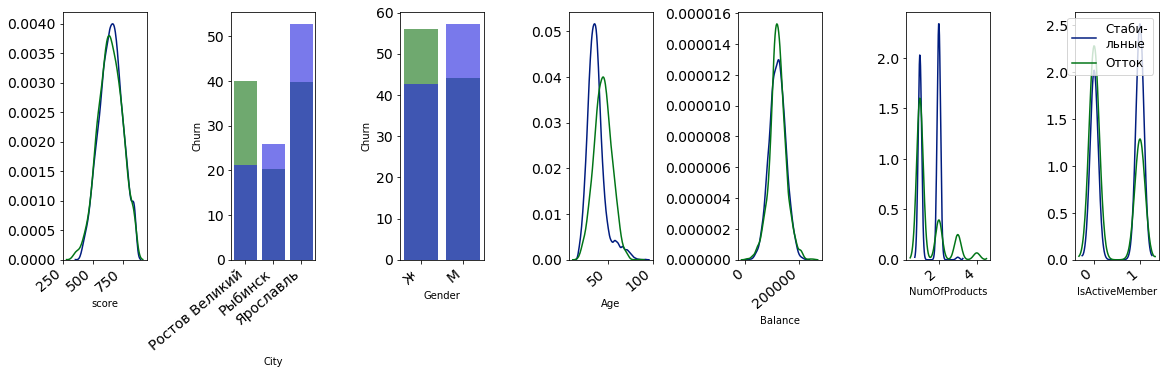

In [115]:
plt.subplots(figsize=(16,5))
one = 0
legend = ['Стаби-\nльные', 'Отток']
for i in churn.columns:
    if i in ('score','Age','Balance','NumOfProducts','IsActiveMember'):
        one += 1
        ax = sns.distplot(not_churn[i], bins=15, ax=plt.subplot(1,7,one), hist=False, label='')
        sns.distplot(churn[i], bins=15, ax=ax, hist=False, label='')
    elif i in ('City','Gender'):
        one += 1
        new1 = (churn.groupby(i)['Churn'].count() / len(churn[i]) * 100).reset_index()
        new2 = (not_churn.groupby(i)['Churn'].count() / len(not_churn[i]) * 100).reset_index()
        axe = sns.barplot(x=new1[i], y=new1['Churn'], ax=plt.subplot(1,7,one), alpha=0.6, label='', color='g')
        sns.barplot(x=new2[i], y=new2['Churn'], ax=axe, alpha=0.6, label='', color='b')
    plt.tight_layout(0.01)
    plt.xticks(fontsize=14, rotation=40, horizontalalignment='right')
    plt.yticks(fontsize=14)
plt.legend(legend, loc='best', fontsize=12)

##### Вывод
Рассмотрим те признаки, по которым разница в группах оказалась значима:
"Кредитный рейтинг", "Город", "Пол", "Возраст", "Баланс карты", "Количество продуктов", "Активный клиент".

По плотности распределения можно заметить, что:
* кредитный рейтинг у стабильных клиентов в среднем выше, чем у группы оттока
* большинство клиентов из группы оттока проживает в Ростове Великом и Ярославле
* в группе оттока женщин больше, чем мужчин
* с 45 лет количество людей в группе стабильных клиентов резко начинает сокращаться, клиенты начинают уходить
* максимальный баланс карты у группы стабильных клиентов незначительно проигрывает максимальному балансу группы оттока, но на продолжении всего периода владения продукта баланс идет нога в ногу
* интересно, что стабильные клиенты предпочитают иметь не более двух продуктов банка, в то время как клиенты из группы оттока расширяют свою линейку до четырех
* группа оттока пассивнее постоянных клиентов

### 4. Кластеризация пользователей <a id="Кластеризация"></a>

*Заполним нулями все пропуски в столбце "Баланс карты" для стандартизации значений признаков и дальнейшего построения дендрограммы кластеризации.*

In [116]:
data.loc[data['Balance'].isna(),'Balance'] = 0

*Стандартизируем данные*

In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sc = scaler.fit_transform(data.drop(columns=['userid','Churn','City','Gender']))

*Строим график дендрограммы для агломеративной иерархической кластеризации*

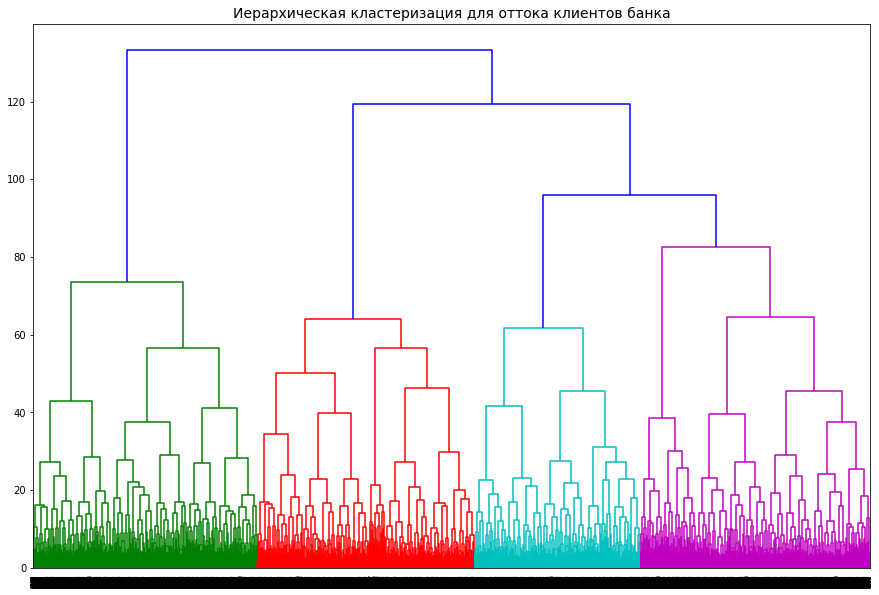

In [118]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(sc, method='ward')
plt.figure(figsize=(15,10))
dendrogram (linked, orientation='top')
plt.title('Иерархическая кластеризация для оттока клиентов банка', fontsize=14)
plt.show()

##### Вывод 
Получилось 4 кластера. Теперь по ним мы сможем провести ранжирование всех клиентов и посмотреть, какие признаки присущи большинству клиентов из группы оттока, выявить закономерности и сформулировать портрет таких клиентов.

*Проводим кластеризацию пользователей методом K-Means*

In [119]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=12345)
labels = km.fit_predict(sc)
data['claster'] = labels
data.drop(columns=['userid']).groupby(['claster'], as_index=False).mean().round(4)

,claster,score,Age,Objects,Balance,NumOfProducts,CreditCard,IsActiveMember,EstimatedSalary,Churn,City_code,Gender_code
0,0,649.3059,38.7445,4.9307,64534.3545,1.5335,0.0000,0.5254,101292.1293,0.1651,1.3423,0.5502
1,1,651.6302,39.7050,5.0033,120704.8820,1.5601,0.7353,0.4956,101287.3131,0.3175,2.9233,0.5251
2,2,651.0101,38.5874,4.9947,121847.8111,1.1406,0.9996,0.5291,99412.0888,0.1682,1.2724,0.5725
3,3,650.0374,38.5744,5.1024,5704.1086,1.8181,0.9989,0.5144,98519.4118,0.1528,1.3221,0.5403


In [120]:
data.groupby(['claster','City_code'])['City_code'].count()

claster  City_code
0        1.0          1467
         2.0           751
         3.0             5
1        2.0           208
         3.0          2504
2        1.0          1661
         2.0           622
3        1.0          1886
         2.0           896
Name: City_code, dtype: int64

##### Вывод 
Самой проблемной получилась группа 1. От остальных групп ее отличает:
* самый высокий кредитный рейтинг
* самый высокий возрастной показатель
* второе место по балансу карты. Стоит учесть при условии, что у кластера 0 баланс в 2 раза меньше, а у кластера 3 - почти незначительный. Учитывая, что мы ранее заменили все пропуски на 0, скорее всего именно группа 3 не хранит деньги на карте и либо их сразу снимает, либо переводит на другую карту
* эта группа наименее активна
* по большей части клиенты проживают в Ростове Великом.

### 5. Машинное обучение и предсказание оттока <a id="Предсказания"></a>

**Попробуем еще раз обучить модель)**

Так как данные по оттоку категориальные, решаем задачу классификации. Т.е. применимые модели для обучения: Решающее дерево (DecisionTreeClassifier), Случайный лес (RandomForestClassifier), Логистическая регрессия (LogisticRegression).
В предложенных данных нам дали модель Решающего дерева с глубиной в 4 уровня. Сравним 3 модели и проверим по метрикам, какая из них лучше справится с предсказанием оттока.

In [121]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from joblib import load
import joblib
from sklearn.tree import DecisionTreeClassifier

*Обозначим 2 датасета для тестовой и валидационной выборки. Столбцы 'City','Gender' удаляем из-за категориальных данных. Столбец 'userid' нам не нужен из-за отсутствия информативности. Столбец 'Churn' удаляем, т.к. по нему делаем обучение моделей*

In [122]:
df_train, df_valid = train_test_split(data, test_size=0.25, random_state=12345)
features_train = df_train.drop(['userid','Churn','City','Gender'], axis=1)
target_train = df_train['Churn']
features_valid = df_valid.drop(['userid','Churn','City','Gender'], axis=1)
target_valid = df_valid['Churn']

*Проверяем модель Случайного леса на лучшее количество деревьев четырьмя метриками*

In [123]:
total_A = []
total_P = []
total_R = []
total_f1 = []
index = []
for i in range(1,50):
    modelRandomForest = RandomForestClassifier(random_state=12345, n_estimators=i)
    modelRandomForest.fit(features_train,target_train)
    predictRF = modelRandomForest.predict(features_valid)
    accuracyRandomForest = accuracy_score(target_valid,predictRF)
    precisionRandomForest = precision_score(target_valid,predictRF)
    recallRandomForest = recall_score(target_valid,predictRF)
    f1 = f1_score(target_valid,predictRF)
    total_A.append(accuracyRandomForest)
    total_P.append(precisionRandomForest)
    total_R.append(recallRandomForest)
    total_f1.append(f1)
    index.append(i)
    metric_RF = {'accuracy':total_A,'precision':total_P,'recall':total_R,'f1':total_f1}
    metrics_RF = pd.DataFrame(data=metric_RF, columns=metric_RF.keys(), index=index)
metrics_RF.sort_values(by='f1', ascending=False).head()

,accuracy,precision,recall,f1
49,0.8552,0.776358,0.454206,0.573113
45,0.8540,0.774194,0.448598,0.568047
37,0.8552,0.785479,0.444860,0.568019
36,0.8556,0.793919,0.439252,0.565584
33,0.8524,0.764331,0.448598,0.565371


##### Вывод
Отсортировав по убыванию данные и взяв за основную метрику f1_score, выберем оптимальное количество деревьев, равное 49. На сколько я поняла, Случайный лес не страдает переобучением и, чем больше у него будет деревьев, тем лучше по результату.

*Обучим модели на тестовой и валидационной выборках, сравним показатели их метрик*

In [125]:
modelRandomForest = RandomForestClassifier(random_state=12345, n_estimators=41, max_depth=8)
modelRandomForest.fit(features_train,target_train)
predictRF_train = modelRandomForest.predict(features_train)
predictRF_valid = modelRandomForest.predict(features_valid)
accuracyRF_train = accuracy_score(target_train,predictRF_train)
accuracyRF_valid = accuracy_score(target_valid,predictRF_valid)
precisionRF_train = precision_score(target_train,predictRF_train)
precisionRF_valid = precision_score(target_valid,predictRF_valid)
recallRF_train = recall_score(target_train,predictRF_train)
recallRF_valid = recall_score(target_valid,predictRF_valid)
f1RF_train = f1_score(target_train,predictRF_train)
f1RF_valid = f1_score(target_valid,predictRF_valid)

modelLogisticRegression = LogisticRegression(random_state=12345)
modelLogisticRegression.fit(features_train,target_train)
predictLR_train = modelLogisticRegression.predict(features_train)
predictLR_valid = modelLogisticRegression.predict(features_valid)
accuracyLR_train = accuracy_score(target_train,predictLR_train)
accuracyLR_valid = accuracy_score(target_valid,predictLR_valid)
precisionLR_train = precision_score(target_train,predictLR_train)
precisionLR_valid = precision_score(target_valid,predictLR_valid)
recallLR_train = recall_score(target_train,predictLR_train)
recallLR_valid = recall_score(target_valid,predictLR_valid)
f1LR_train = f1_score(target_train,predictLR_train)
f1LR_valid = f1_score(target_valid,predictLR_valid)

modelDecisionTreeClassifier = joblib.load('model.joblib')
modelDecisionTreeClassifier.fit(features_train,target_train)
predictDTC_train = modelDecisionTreeClassifier.predict(features_train)
predictDTC_valid = modelDecisionTreeClassifier.predict(features_valid)
accuracyDTC_train = accuracy_score(target_train,predictDTC_train)
accuracyDTC_valid = accuracy_score(target_valid,predictDTC_valid)
precisionDTC_train = precision_score(target_train,predictDTC_train)
precisionDTC_valid = precision_score(target_valid,predictDTC_valid)
recallDTC_train = recall_score(target_train,predictDTC_train)
recallDTC_valid = recall_score(target_valid,predictDTC_valid)
f1DTC_train = f1_score(target_train,predictDTC_train)
f1DTC_valid = f1_score(target_valid,predictDTC_valid)

metric = {'Random Forest train':[accuracyRF_train,precisionRF_train,recallRF_train,f1RF_train],
          'Random Forest valid':[accuracyRF_valid,precisionRF_valid,recallRF_valid,f1RF_valid],
          'Logistic Regression train':[accuracyLR_train,precisionLR_train,recallLR_train,f1LR_train],
          'Logistic Regression valid':[accuracyLR_valid,precisionLR_valid,recallLR_valid,f1LR_valid],
          'Decision Tree Classifier train':[accuracyDTC_train,precisionDTC_train,recallDTC_train,f1DTC_train],
         'Decision Tree Classifier valid':[accuracyDTC_valid,precisionDTC_valid,recallDTC_valid,f1DTC_valid]}
metrics = pd.DataFrame(data=metric, index=['accuracy', 'precision', 'recall', 'f1'])
metrics

C:\Users\Arina\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Random Forest train,Random Forest valid,Logistic Regression train,Logistic Regression valid,Decision Tree Classifier train,Decision Tree Classifier valid
accuracy,0.883067,0.854800,0.793867,0.781600,0.853600,0.841200
precision,0.907432,0.823308,0.399083,0.430380,0.817610,0.792373
recall,0.463382,0.409346,0.057923,0.063551,0.346205,0.349533
f1,0.613486,0.546816,0.101163,0.110749,0.486436,0.485084


##### Вывод
Добавила глубину 8 уровней в модель Случайного леса, без него она вела себя неадекватно. Пробовала разное число глубины до 10. Начиная с глубины 6 Случайный лес становится лучше по предсказанию, чем Решающее дерево. По метрике f1 для дальнейшего предсказания проходит Random Forest с количеством деревьев 49.

*Попробуем предсказать отток в имеющемся датасете*

In [126]:
new_data = data[data['Churn'] == 0].drop(['userid','Churn','City','Gender'], axis=1)

predictRF_new_data = modelRandomForest.predict(new_data)
new_data['future_churn'] = predictRF_new_data
new_data.groupby('future_churn').mean().round(4)

,score,Age,Objects,Balance,NumOfProducts,CreditCard,IsActiveMember,EstimatedSalary,City_code,Gender_code,claster
future_churn,,,,,,,,,,,
0,651.8488,37.2316,5.0380,72359.9954,1.5482,0.7062,0.5591,99673.9789,1.6741,0.5758,1.6010
1,652.1441,49.1610,4.7203,98361.3060,1.2797,0.7712,0.2542,104020.7553,2.4068,0.3559,1.3559


In [127]:
new_data.groupby('future_churn')['claster'].count().reset_index()

,future_churn,claster
0,0,7845
1,1,118


In [128]:
new_data.groupby(['future_churn','City_code'])['claster'].count().reset_index()

,future_churn,City_code,claster
0,0,1.0,4175
1,0,2.0,2052
2,0,3.0,1618
3,1,1.0,29
4,1,2.0,12
5,1,3.0,77


In [129]:
new_data.groupby(['future_churn','Gender_code'])['claster'].count().reset_index()

,future_churn,Gender_code,claster
0,0,0.0,3328
1,0,1.0,4517
2,1,0.0,76
3,1,1.0,42


##### Вывод 
В среднем у предсказанной группы оттока в 118 человек кредитный рейтинг получился меньше стабильных клиентов. Но по возрасту они остались в самой возрастной группе, имеют больший баланс на карте, чем постоянные клиенты, менее активны, проживают в большинстве своем в Ростове Великом. Кстати, женщин получилось больше, чем мужчин.

*Проверим количество клиентов из предсказанной группы оттока в каждом кластере*

In [130]:
new_data.groupby(['future_churn','claster'])['score'].count().reset_index()

,future_churn,claster,score
0,0,0,1847
1,0,1,1774
2,0,2,1886
3,0,3,2338
4,1,0,9
5,1,1,77
6,1,2,13
7,1,3,19


##### Вывод 
И по кластеризации Случайный лес также выделил проблемной именно первую группу.

### 6. Выводы <a id="Выводы"></a>

Проведя исследовательский анализ данных мы проанализировали пропуски в балансе карт у клиентов банка. По среднему значению увидели, что разница между оттоком и постоянными клиентами значительна в возрасте и активности клиента. Построили графики по количеству клиентов из групп оттока и постоянных клиентов и их доле в признаках. Сделали вывод, что очевидная разница в группах состоит в возрасте, активности клиента, месте его проживания и его полу

По статистическому анализу вычислили, что разница в средних ощутима для постоянных клиентов и из группы оттока по столбцам "Кредитный рейтинг", "Возраст", "Баланс карты", "Количество продуктов", "Активный клиент", "Город", "Пол". Рассмотрев их по плотности распределения клиентов, сделали выводы:
* кредитный рейтинг у стабильных клиентов в среднем выше, чем у группы оттока
* большинство клиентов из группы оттока проживает в Ростове Великом и Ярославле
* в группе оттока женщин больше, чем мужчин
* с 45 лет количество людей в группе стабильных клиентов резко начинает сокращаться, клиенты начинают уходить
* максимальный баланс карты у группы стабильных клиентов незначительно проигрывает максимальному балансу группы оттока, но на продолжении всего периода владения продукта баланс идет нога в ногу
* интересно, что стабильные клиенты предпочитают иметь не более двух продуктов банка, в то время как клиенты из группы оттока расширяют свою линейку до четырех
* группа оттока пассивнее постоянных клиентов

Проведя кластеризацию, получили 4 кластера. По ним провели ранжирование всех клиентов. Самой проблемной получилась группа 1. От остальных групп ее отличает:
* самый высокий кредитный рейтинг
* самый высокий возрастной показатель
* второе место по балансу карты. Стоит учесть при условии, что у кластера 0 баланс в 2 раза меньше, а у кластера 3 - почти незначительный. Учитывая, что мы ранее заменили все пропуски на 0, скорее всего именно группа 3 не хранит деньги на карте и либо их сразу снимает, либо переводит на другую карту
* эта группа наименее активна
* по большей части клиенты проживают в Ростове Великом.

**В итоге составим портрет уходящего клиента:**

Самым рисковым (уходящим) клиентом скорее всего окажется женщина старше 50 лет, проживающая в Ростове Великом, со стандартным кредитным рейтингом. По большому счету она не будет активно пользоваться всеми своими разнообразными продуктами банка, но будет иметь значительную сумму на балансе.

По кластеризации необходимо уделить тщательное внимание группе 1. Также по предсказанию группа 1 находится на первом месте по предполагаемому оттоку. С клиентами можно попробовать провести дополнительную работу для закрепления в этом банке. Навязывание внутренних продуктов, судя по анализу, не способствует решению проблемы. А вот на отсутствие денег на балансе карт у многих стабильных клиентов стоит обратить внимание. Возможно деньги переводятся в другой банк. Вряд ли в России люди сидят на наличке. Это больше свойственно Европейскому потребителю. Есть предложение по внедрению популярной сейчас среди банков акции в виде cashback. Можно добавить процент на ежемесячный остаток по счету, чтобы клиент оставлял средства на карте данного банка на длительно время или хранение.

### 7. Список источников: <a id="Источники"></a>
1. https://progresscard.ru/pages-credit-score
Сайт помог разобраться с кредитным рейтингом и его стандартными значениями
2. https://seaborn.pydata.org/examples/distplot_options.html
Хороший пример построения графика 2х2. Впоследствии не пригодился, но попытки были
3. https://stackoverflow.com/
Очень много хороших идей по решению проблем при написании кода
4. https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html
Сайт помог решить задачу с построением subplot
5. https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html
Ошибки, которые вылезали в ходе решения проекта, были вполне подробно описаны на этой странице и подталкивали к нахождению другого пути решения задачи.